In [13]:
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from myTools import get_read_cut_data

In [5]:
# reading in raw data
df_700 = pd.read_csv('/n/groups/marks/users/david/github/pareSingleLibrary2/codebase/pairedEnd/ex62_gvp/raw_data/700.csv', index_col = 0)
df_704 = pd.read_csv('/n/groups/marks/users/david/github/pareSingleLibrary2/codebase/pairedEnd/ex62_gvp/raw_data/704.csv', index_col = 0)
df_10x = pd.read_csv('/n/groups/marks/users/david/github/pareSingleLibrary2/codebase/pairedEnd/ex62_gvp/raw_data/10x.csv', index_col = 0)


def get_pos(muts):
    #take a mutstr like I33S:L47K:D51S:I52L:R54S:L55E, and return list of positions
    if muts == 'wtAT':
        return [0]
    else:
        mut_pos = [int(k[1:-1]) for k in muts.split(':')]
        return mut_pos

def all_muts_in_exp(poss, expPoss):
    # check whether all positions in first list are found in the second list
    all_exp = True
    for p in poss:
        if p not in expPoss+[0]: # 0 codes for wtat
            all_exp = False
    return all_exp


# M1
# 700: 48, 52, 53, 55,56
# 704: 74, 78, 80, 81, 82

exp_pos_700 = [47,51,52,54,55]
exp_pos_704 = [73, 77, 79, 80, 81]
exp_pos_10x = exp_pos_700 + exp_pos_704
df_700['pos_exp'] = df_700.apply(lambda r: all_muts_in_exp(get_pos(r.name), exp_pos_700), axis=1)
df_704['pos_exp'] = df_704.apply(lambda r: all_muts_in_exp(get_pos(r.name), exp_pos_704), axis=1)
df_10x['pos_exp'] = df_10x.apply(lambda r: all_muts_in_exp(get_pos(r.name), exp_pos_10x), axis=1)


df_700_exp= df_700[df_700.pos_exp==True].dropna()
df_704_exp= df_704[df_704.pos_exp==True].dropna()
df_10x_exp= df_10x[df_10x.pos_exp==True].dropna()


# create the full length mutt_str
#700: L48, D52, I53, R55,L56
wt_muts_700 = 'L47L:D51D:I52I:R54R:L55L'

# 704: F74, R78, E80, A81, R82
wt_muts_704 = 'F73F:R77R:E79E:A80A:R81R'

wt_muts_10x = wt_muts_700 +':' + wt_muts_704

def make_full_mutstr(muts, wt_muts):
    # to go from L47G to the full mutstr for all mutated positions
    if muts == 'wtAT':
        return wt_muts
    else:
        curr_mut_list = muts.split(':')
        curr_mut_pos_to_mut = dict(zip([m[:-1] for m in curr_mut_list], curr_mut_list))
        new_mut_list = []

        for wt_mut in wt_muts.split(':'):
            if wt_mut[:-1] not in curr_mut_pos_to_mut:
                new_mut_list.append(wt_mut)
            else:
                new_mut_list.append(curr_mut_pos_to_mut[wt_mut[:-1]])
        return ':'.join(new_mut_list)


df_700_exp['muts'] = df_700_exp.apply(lambda r: make_full_mutstr(r.name, wt_muts_700), axis=1)
df_704_exp['muts'] = df_704_exp.apply(lambda r: make_full_mutstr(r.name, wt_muts_704), axis=1)
df_10x_exp['muts'] = df_10x_exp.apply(lambda r: make_full_mutstr(r.name, wt_muts_10x), axis=1)

# create them all together
df_all_exp = pd.concat([df_700_exp, df_704_exp, df_10x_exp], axis=0)
df_all_exp['muts'] = df_all_exp.apply(lambda r: make_full_mutstr(r.name, wt_muts_10x), axis=1)
df_all_exp

# create just 10x and 704 together

df_704_10x_exp = pd.concat([df_704_exp, df_10x_exp], axis=0)
df_704_10x_exp['muts'] = df_704_10x_exp.apply(lambda r: make_full_mutstr(r.name, wt_muts_10x), axis=1)

# say whether stop or not, wt or not
df_700_exp['stop'] = df_700_exp.apply(lambda r: '_' in r.muts, axis=1)
df_704_exp['stop'] = df_704_exp.apply(lambda r: '_' in r.muts, axis=1)
df_10x_exp['stop'] = df_10x_exp.apply(lambda r: '_' in r.muts, axis=1)
df_all_exp['stop'] = df_all_exp.apply(lambda r: '_' in r.muts, axis=1)
df_704_10x_exp['stop'] = df_704_10x_exp.apply(lambda r: '_' in r.muts, axis=1)

df_700_exp['wt'] = df_700_exp.apply(lambda r:  r.muts == wt_muts_700, axis=1)
df_704_exp['wt'] = df_704_exp.apply(lambda r: r.muts == wt_muts_704, axis=1)
df_10x_exp['wt'] = df_10x_exp.apply(lambda r: r.muts == wt_muts_10x, axis=1)
df_all_exp['wt'] = df_all_exp.apply(lambda r: r.muts == wt_muts_10x, axis=1)
df_704_10x_exp['wt'] = df_704_10x_exp.apply(lambda r: r.muts == wt_muts_10x, axis=1)


# normalize to between 0 and 1
def norm_lrr(df):
    df['mean_lrr'] = (df['lrr1'] + df['lrr2'])/2

    df_stop = df[df.stop == True]
    df_wt = df[df.wt == True]

    mean_lrr_stop = np.mean(df_stop.mean_lrr)
    mean_lrr_wt = np.mean(df_wt.mean_lrr)

    df['mean_lrr_norm'] = (df.mean_lrr - mean_lrr_stop) / (mean_lrr_wt - mean_lrr_stop)

    df['lrr1_norm'] = (df.lrr1 - np.mean(df_stop['lrr1'])) / (np.mean(df_wt['lrr1']) - np.mean(df_stop['lrr1']))
    df['lrr2_norm'] = (df.lrr2 - np.mean(df_stop['lrr2'])) / (np.mean(df_wt['lrr2']) - np.mean(df_stop['lrr2']))

norm_lrr(df_700_exp)
norm_lrr(df_704_exp)
norm_lrr(df_10x_exp)
norm_lrr(df_all_exp)
norm_lrr(df_704_10x_exp)

In [16]:
df= df_704_10x_exp
read_cut=3
df_read = df[(df.pre1>read_cut) &(df.pre2 > read_cut) & (df.post1>read_cut) &(df.post2 > read_cut)]
len(df_read)
norm_lrr(df_read)

/tmp/ipykernel_4185/3013101328.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mean_lrr'] = (df['lrr1'] + df['lrr2'])/2
/tmp/ipykernel_4185/3013101328.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mean_lrr_norm'] = (df.mean_lrr - mean_lrr_stop) / (mean_lrr_wt - mean_lrr_stop)
/tmp/ipykernel_4185/3013101328.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

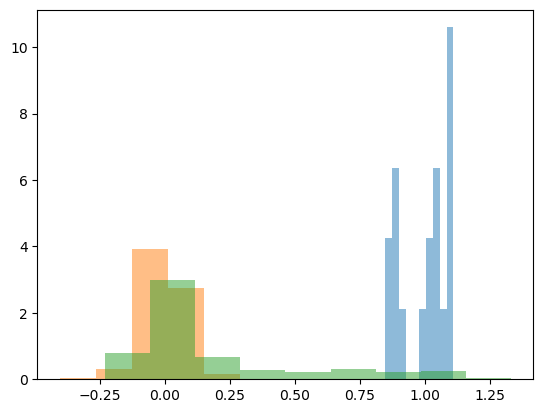

In [17]:
plt.figure()
plt.hist(df_read.loc[df_read.hamming == 0].mean_lrr_norm, alpha=0.5,density=True)
plt.hist(df_read.loc[df_read.stop == True].mean_lrr_norm, alpha=0.5, density=True)
plt.hist(df_read.mean_lrr_norm, density=True, alpha=0.5)
plt.show()

df_read'/n/groups/marks/users/david/ex62/data/df_704_10x_rc3_col_processed.csv'

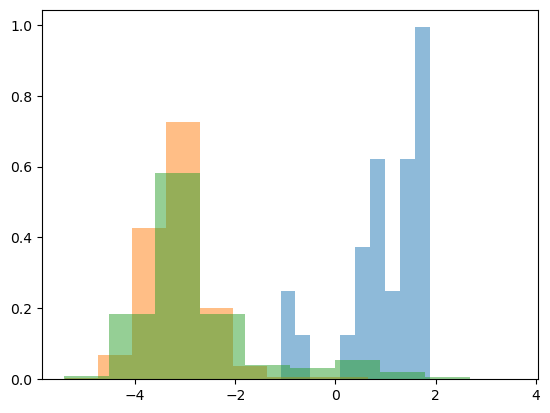

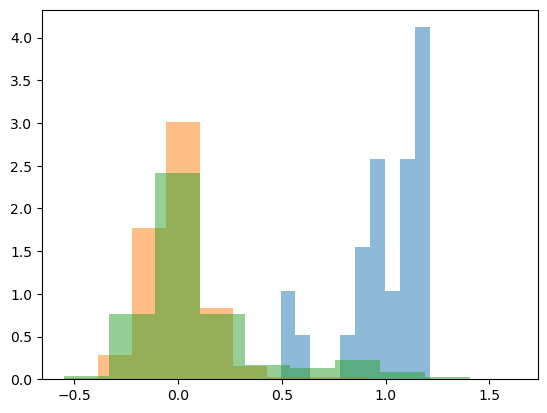

In [11]:
# normalized on total variants without read cutoff
df_704_10x_exp
df_704_10x_exp['hamming'] = df_704_10x_exp.apply(
                                        lambda r: int(np.sum([mut[0]!= mut[-1] for mut in r.muts.split(':')])), 
    axis=1)
plt.figure()
plt.hist(df_704_10x_exp.loc[df_704_10x_exp.hamming == 0].mean_lrr, alpha=0.5,density=True)
plt.hist(df_704_10x_exp.loc[df_704_10x_exp.stop == True].mean_lrr, alpha=0.5, density=True)
plt.hist(df_704_10x_exp.mean_lrr, density=True, alpha=0.5)
plt.show()

plt.figure()
plt.hist(df_704_10x_exp.loc[df_704_10x_exp.hamming == 0].mean_lrr_norm, alpha=0.5,density=True)
plt.hist(df_704_10x_exp.loc[df_704_10x_exp.stop == True].mean_lrr_norm, alpha=0.5, density=True)
plt.hist(df_704_10x_exp.mean_lrr_norm, density=True, alpha=0.5)
plt.show()